<a href="https://colab.research.google.com/github/yigagilbert/beanLeaf/blob/main/bean_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [15]:
dataset = tfds.builder('beans')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [16]:
info.features

FeaturesDict({
    'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})

In [17]:
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [18]:
list(info.splits.keys())

['test', 'train', 'validation']

In [19]:
(train, val, test) = tfds.load("beans", split=["train", "validation","test"])

In [20]:
type(train)
type(val)
type(test)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [21]:
datapoint = next(iter(train))
datapoint

{'image': <tf.Tensor: shape=(500, 500, 3), dtype=uint8, numpy=
 array([[[149, 132, 106],
         [141, 124,  98],
         [134, 118,  95],
         ...,
         [129, 152,  64],
         [129, 152,  64],
         [130, 153,  65]],
 
        [[151, 134, 108],
         [140, 124,  98],
         [133, 117,  94],
         ...,
         [126, 149,  61],
         [127, 150,  62],
         [127, 150,  62]],
 
        [[150, 134, 108],
         [140, 124,  98],
         [133, 117,  94],
         ...,
         [126, 151,  60],
         [125, 150,  59],
         [122, 147,  56]],
 
        ...,
 
        [[ 20,  33,  49],
         [ 21,  34,  50],
         [ 23,  36,  52],
         ...,
         [149, 211, 112],
         [145, 204, 120],
         [142, 200, 123]],
 
        [[ 21,  34,  50],
         [ 22,  35,  51],
         [ 23,  36,  52],
         ...,
         [151, 213, 114],
         [142, 201, 117],
         [136, 194, 118]],
 
        [[ 21,  34,  50],
         [ 21,  34,  50],
     

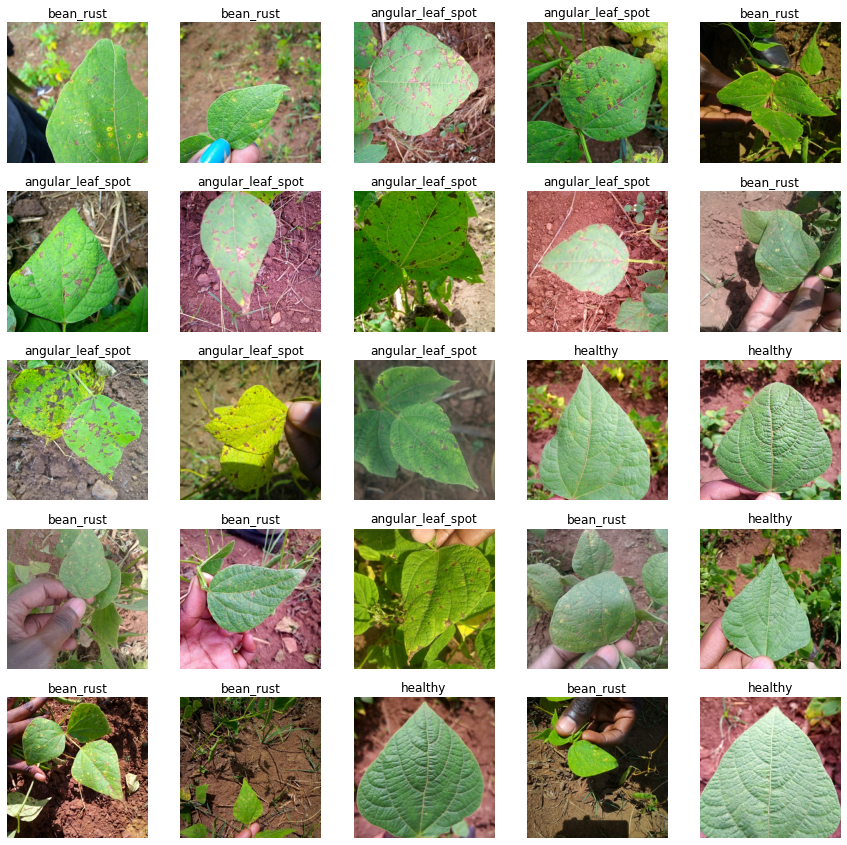

In [22]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [23]:
NUM_EPOCHS = 5
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

In [24]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.7251563>

In [25]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [26]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

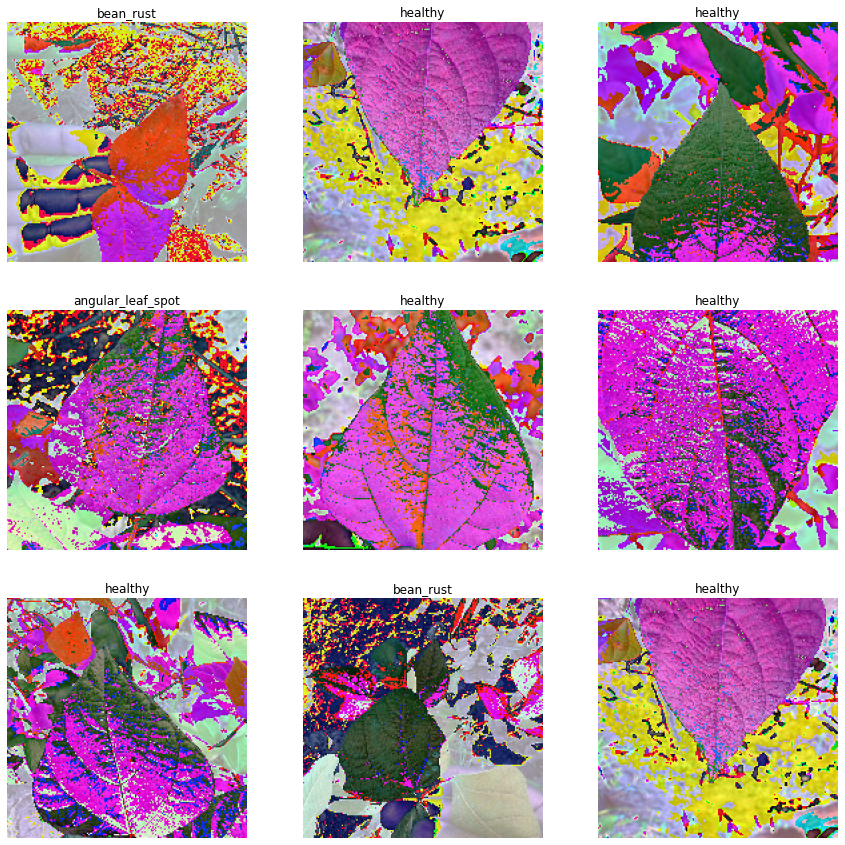

In [27]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0].astype('uint8'))
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

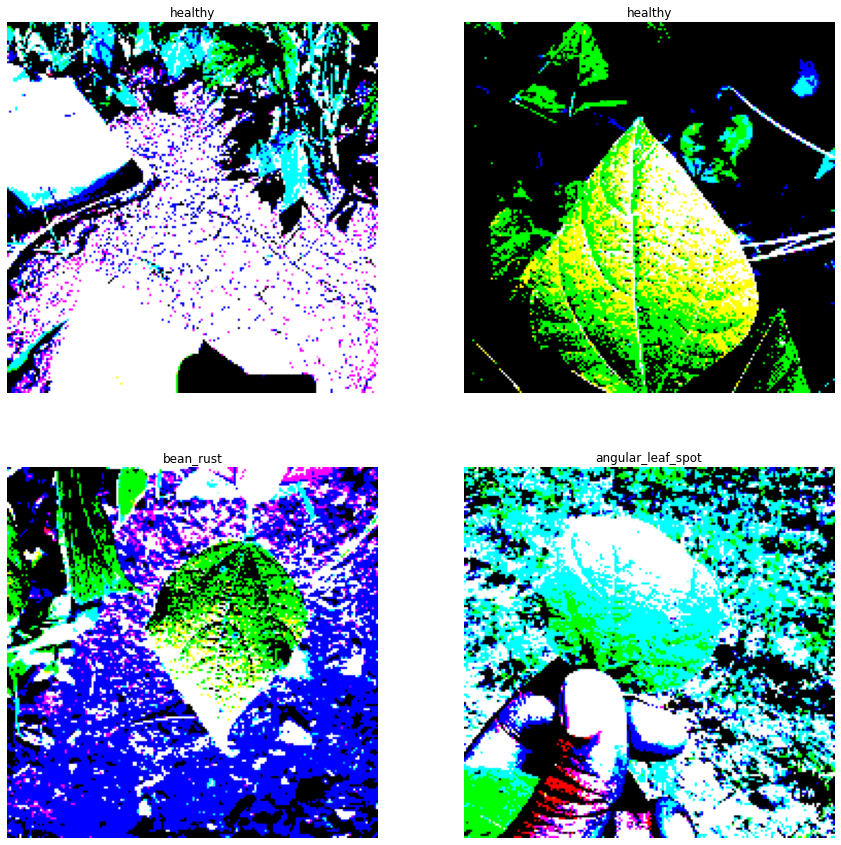

In [28]:
plt.figure(figsize=(15, 15))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0])
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

In [29]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predicition)

94781440/94765736 [==============================] - 1s 0us/step


In [30]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [31]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [32]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
6/6 [==============================] - 19s 271ms/step - loss: 2.1612 - accuracy: 0.4818
Epoch 2/5
6/6 [==============================] - 2s 309ms/step - loss: 0.9224 - accuracy: 0.7262
Epoch 3/5
6/6 [==============================] - 1s 221ms/step - loss: 0.8165 - accuracy: 0.7323
Epoch 4/5
6/6 [==============================] - 2s 265ms/step - loss: 0.5219 - accuracy: 0.8086
Epoch 5/5
6/6 [==============================] - 1s 224ms/step - loss: 0.3191 - accuracy: 0.8800


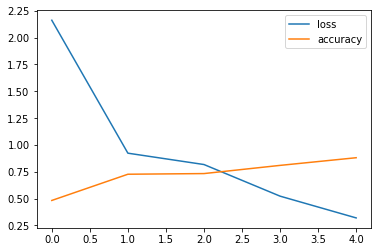

In [33]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

In [34]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [35]:
model.evaluate(test_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.3459 - accuracy: 0.8516


[0.3458917438983917, 0.8515625]

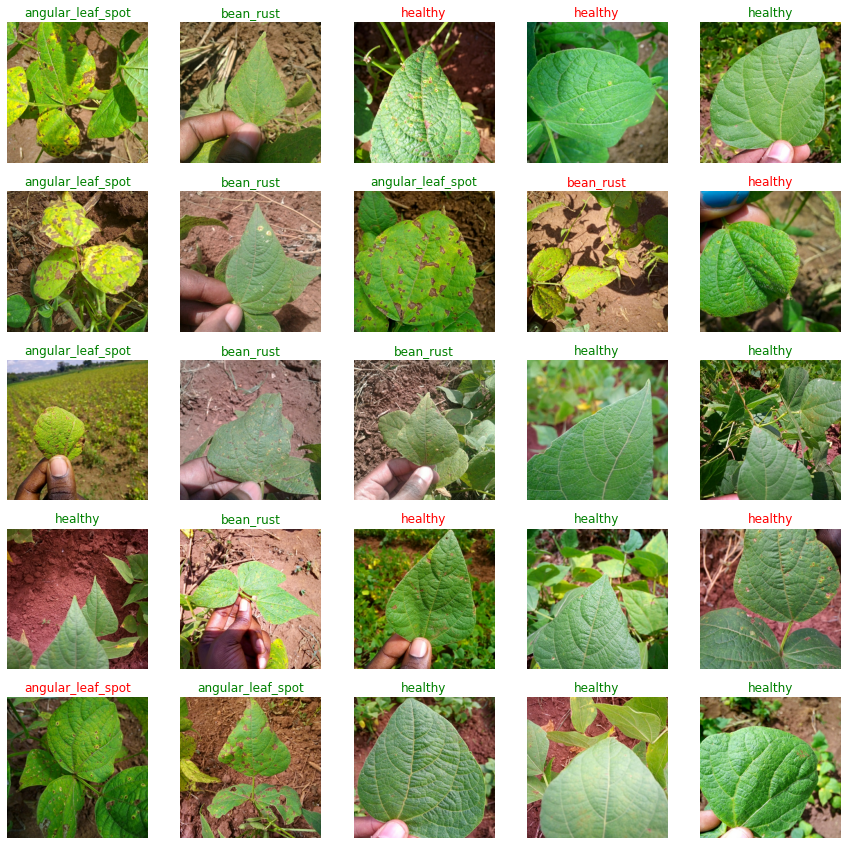

In [36]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()